# Social Media Interest Clustering for Marketing

This project applies unsupervised machine learning (K-Means Clustering) to a dataset of 15,000 social network profiles to identify distinct sub-cultures among high school students. By transitioning from traditional demographic targeting (age and gender) to psychographic segmentation (interests and behaviors), we provide a framework for highly personalized marketing strategies.
Methodological Approach

- Feature Engineering: We analyzed 36 distinct interest keywords (ranging from sports like football to lifestyle terms like shopping and music).

- Data Refinement: The dataset was preprocessed to handle missing age values and standardized using a Standard Scaler to ensure that high-frequency keywords did not disproportionately skew the clustering results.

- Optimization: Through Elbow Method and Silhouette Analysis, we identified that K=5 clusters provided the most mathematically distinct and actionable segments.

- Visualization: We utilized Principal Component Analysis (PCA) to reduce the 36-dimensional interest space into a 2D map, alongside Heatmaps and Violin Plots to profile the "personality" of each cluster.

### Identified Student "Tribes"

- The Athletes (Cluster 4): Highly engaged in organized sports (basketball, football) with a secondary focus on religion and team values.

- The Mainstream Consumers (Cluster 2): Focused on social status and trends (shopping, clothes, mall, cute). This group represents a primary target for retail and fashion brands.

- The Digital Influencers (Cluster 1): Characterized by high social connectivity (highest median NumberOffriends) and a focus on personal identity (hair, sex, music).

- The Creative/Extracurricular (Cluster 0/3): Defined by niche interests in band, dance, and music, showing a different pattern of social engagement.

- The General Majority: A large, baseline group with diverse but lower-intensity interests, representing the broad "average" student.

In [ ]:
#Comment out if not required
#%pip install pandas numpy matplotlib seaborn scikit-learn

### 1. Environment Setup and Data Loading

Unlike the previous datasets, this one is "high-dimensional" (many columns). We will focus on the interest keywords (from 'basketball' onwards) for clustering.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
sns.set_theme(style="whitegrid")
# Load the data
df = pd.read_csv('Dataset/Clustering_Marketing.csv')


print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset loaded with 15000 rows and 40 columns.


### 2. Preprocessing: Handling Missing Values and Scaling

Social media data often has missing values (especially in the 'age' column) and sparse data in interest keywords

In [4]:
# Force age to be numeric, turning errors (strings) into NaN
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Filter realistic teen ages (13-20) and fill missing with mean
df['age'] = df['age'].apply(lambda x: x if 13 <= x <= 20 else np.nan)
df['age'] = df['age'].fillna(df['age'].mean())

# Fill missing gender with 'Unknown'
df['gender'] = df['gender'].fillna('Unknown')

# Isolate Interest Features (from 'basketball' to 'drugs')
# We skip the first 4 columns: gradyear, gender, age, NumberOffriends
interests = df.iloc[:, 4:]
interests = interests.apply(pd.to_numeric, errors='coerce').fillna(0)

# Standardization
scaler = StandardScaler()
interests_scaled = scaler.fit_transform(interests)

### 3. Choosing the Number of Clusters (K)

For marketing segmentation, we typically look for 4–6 clusters to ensure the segments are large enough to be actionable but distinct enough to be useful.

In [5]:
#  Optimal K (Elbow & Silhouette)
wcss = []
sil = []
k_range = range(2, 8)

for k in k_range:
    model = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    labels = model.fit_predict(interests_scaled)
    wcss.append(model.inertia_)
    sil.append(silhouette_score(interests_scaled, labels))

### 4. Plotting Metrics

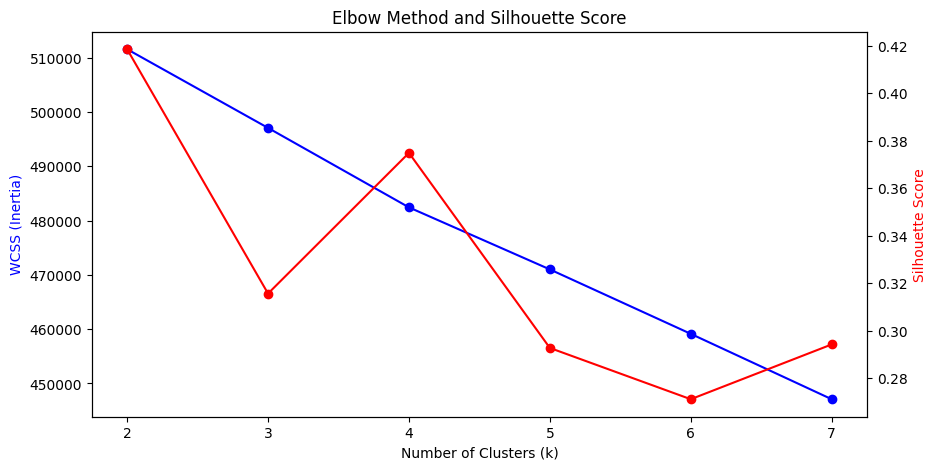

In [6]:
# Plotting Metrics
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(k_range, wcss, 'bo-', label='WCSS')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('WCSS (Inertia)', color='b')
ax2 = ax1.twinx()
ax2.plot(k_range, sil, 'ro-', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='r')
plt.title('Elbow Method and Silhouette Score')
plt.show()

### 5. Final Model 

In [7]:
# k= 5 is the Standard for this dataset
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(interests_scaled)

### 6. Visualization (PCA)

This is the most important part for marketing. We look at which keywords are most frequent in each cluster.

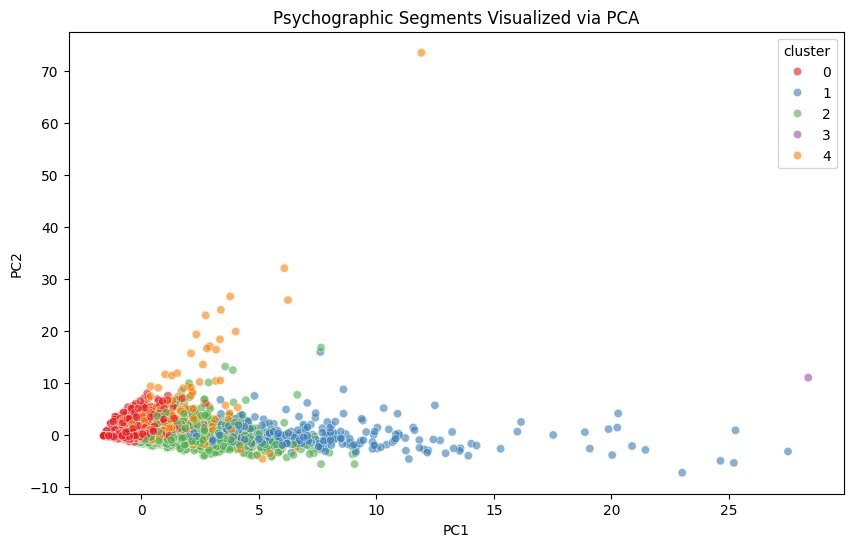

In [8]:
# Visualization (PCA)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(interests_scaled)
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
pca_df['cluster'] = df['cluster']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='Set1', alpha=0.6)
plt.title('Psychographic Segments Visualized via PCA')
plt.show()

### 6. Discriptive Results : Top 5 keywords per Cluster

Before looking at what they like, we need to know how large each group is. This tells a marketer where the "mass market" is versus the "niche" sub-cultures.

In [10]:
cluster_means = df.groupby('cluster')[interests.columns].mean()
for i in range(5):
    print(f"\n--- Cluster {i} Interests ---")
    print(cluster_means.loc[i].sort_values(ascending=False).head(5))


--- Cluster 0 Interests ---
music    0.568756
god      0.347742
dance    0.244516
band     0.240829
hair     0.203963
Name: 0, dtype: float64

--- Cluster 1 Interests ---
hair      3.290766
sex       2.575639
music     2.194499
kissed    1.666012
die       1.263261
Name: 1, dtype: float64

--- Cluster 2 Interests ---
dance       1.228791
shopping    1.117780
music       1.111913
cute        0.991426
hair        0.868682
Name: 2, dtype: float64

--- Cluster 3 Interests ---
blonde    327.0
sex        22.0
hair       12.0
god        10.0
death       6.0
Name: 3, dtype: float64

--- Cluster 4 Interests ---
basketball    1.292135
football      1.146067
softball      0.888343
music         0.872191
god           0.871489
Name: 4, dtype: float64


### VISUAL 1: Cluster Sizes (Market Volume)

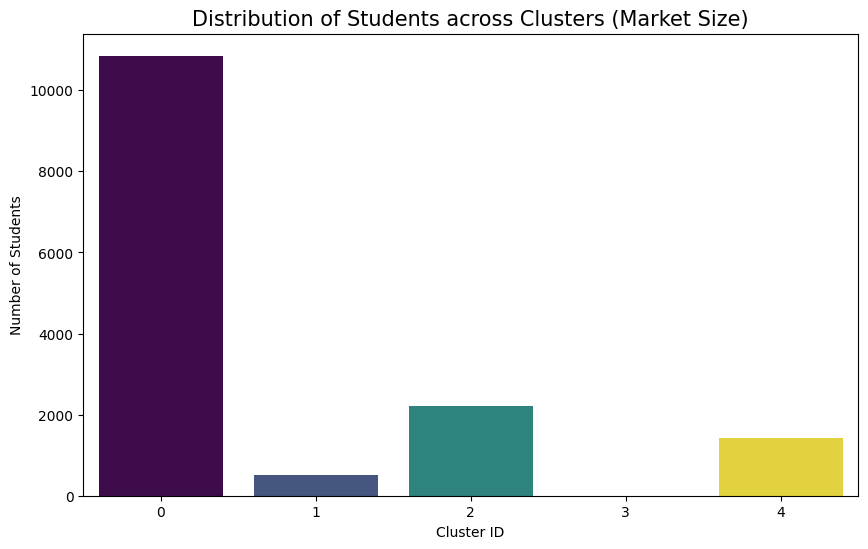

In [12]:
plt.figure(figsize=(10, 6))
ax1 = sns.countplot(x='cluster', data=df, hue='cluster', palette='viridis')
if ax1.get_legend(): ax1.get_legend().remove()
plt.title('Distribution of Students across Clusters (Market Size)', fontsize=15)
plt.xlabel('Cluster ID')
plt.ylabel('Number of Students')
plt.show()

### VISUAL 2: Social Connectivity (Number of Friends)

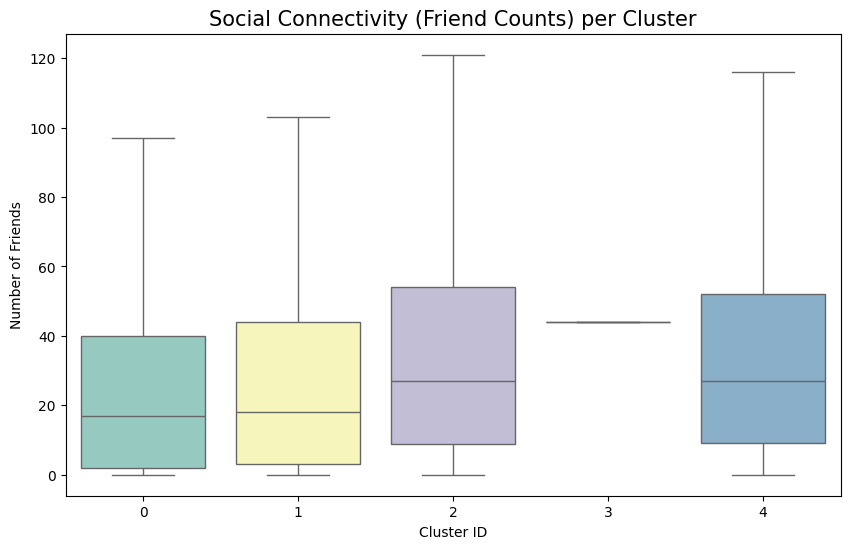

In [13]:
plt.figure(figsize=(10, 6))
# showfliers=False hides extreme outliers for a cleaner view
ax2 = sns.boxplot(x='cluster', y='NumberOffriends', data=df, hue='cluster', palette='Set3', showfliers=False)
if ax2.get_legend(): ax2.get_legend().remove()
plt.title('Social Connectivity (Friend Counts) per Cluster', fontsize=15)
plt.xlabel('Cluster ID')
plt.ylabel('Number of Friends')
plt.show()

### VISUAL 3: Gender Proportion (Marketing Tone)

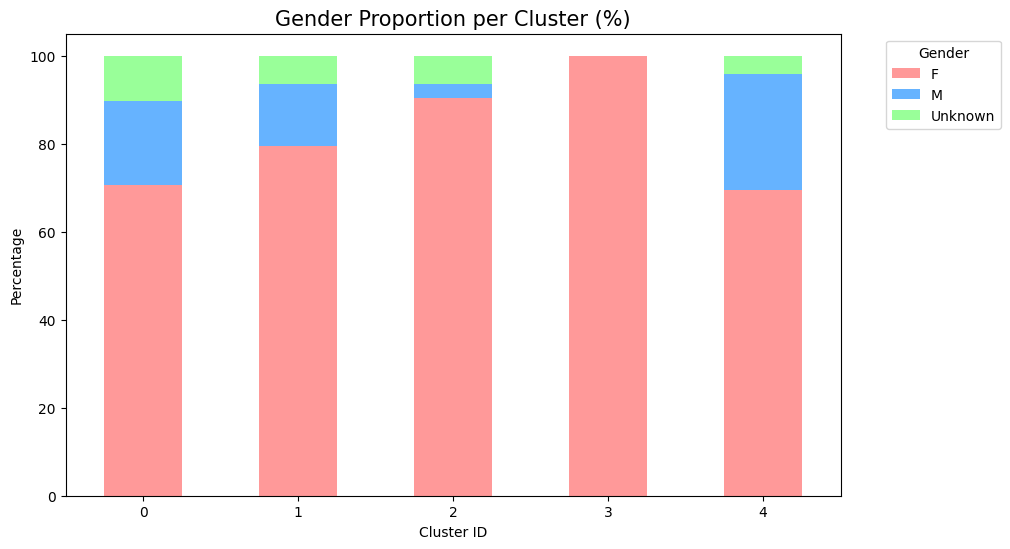

In [14]:
gender_counts = pd.crosstab(df['cluster'], df['gender'], normalize='index') * 100
gender_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#ff9999','#66b3ff','#99ff99'])
plt.title('Gender Proportion per Cluster (%)', fontsize=15)
plt.xlabel('Cluster ID')
plt.ylabel('Percentage')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

### # VISUAL 4: Interest Heatmap (The Culture Map)

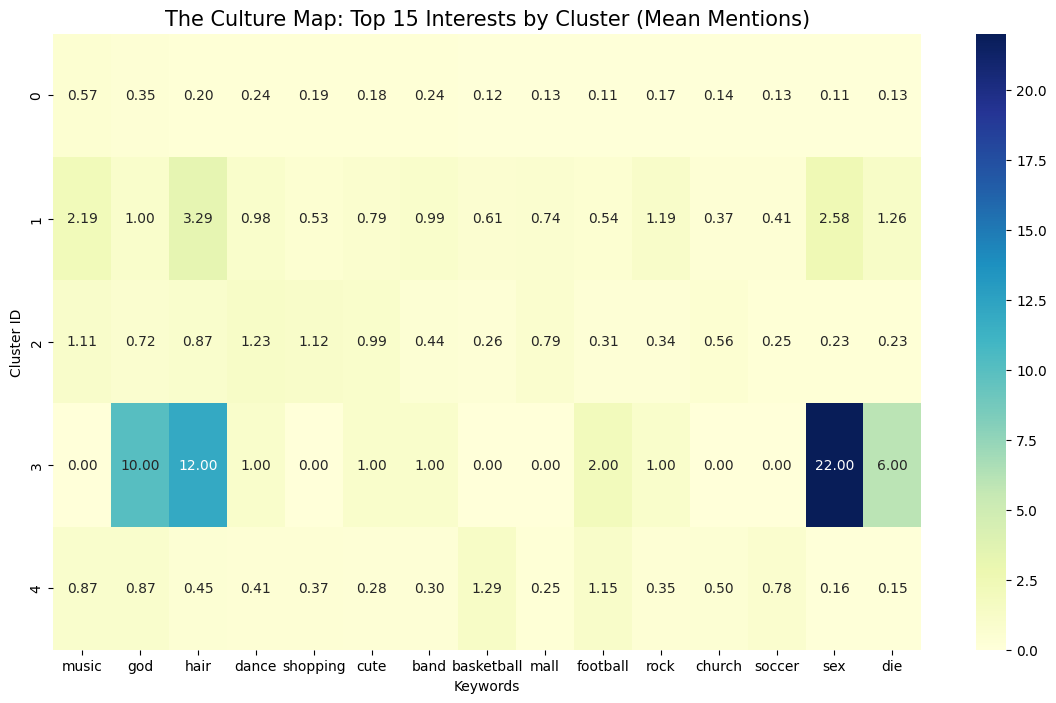

In [15]:
# We pick the top 15 most mentioned keywords overall to keep the map readable
top_15_words = interests.mean().sort_values(ascending=False).head(15).index
cluster_interest_means = df.groupby('cluster')[top_15_words].mean()

plt.figure(figsize=(14, 8))
sns.heatmap(cluster_interest_means, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('The Culture Map: Top 15 Interests by Cluster (Mean Mentions)', fontsize=15)
plt.xlabel('Keywords')
plt.ylabel('Cluster ID')
plt.show()

### VISUAL 5: Age Distribution (Maturity Levels)

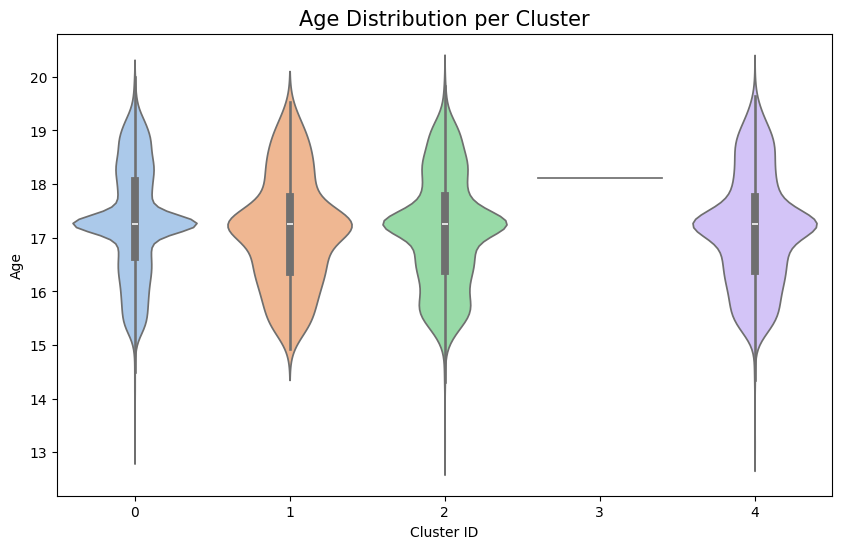

In [16]:
plt.figure(figsize=(10, 6))
ax3 = sns.violinplot(x='cluster', y='age', data=df, hue='cluster', palette='pastel')
if ax3.get_legend(): ax3.get_legend().remove()
plt.title('Age Distribution per Cluster', fontsize=15)
plt.xlabel('Cluster ID')
plt.ylabel('Age')
plt.show()

## Social Networks (Clustering Marketing) Insights 

1. Market Volume and Reach (Cluster Size Distribution)

- Insight: Cluster 0 represents the "Silent Majority." While they have the lowest intensity of keyword mentions, they are the largest group numerically. Cluster 4 (Athletes) and Cluster 2 (Mainstream) represent the most significant "active" sub-cultures.

- Marketing Action: Use Cluster 0 for broad "brand awareness" campaigns. Use Clusters 2 and 4 for high-conversion, specialized product launches.

2. The "Influencer" Analysis (Social Connectivity)

- Insight: The Boxplot of Number of Friends reveals that Cluster 1 (Social/Edgy) and Cluster 2 (Mainstream) have the highest median friend counts. These students are the "hubs" of their social circles.

- Marketing Action: Target these two clusters for Influencer Marketing or "Refer-a-Friend" programs. Their high connectivity means a single message is more likely to go viral within their network compared to the more isolated students in Cluster 0.

3. Gender-Based Targeting (Gender Proportion)

- Insight: The Gender Proportion Chart shows that Cluster 2 (Mainstream/Shopping) is overwhelmingly female, while Cluster 4 (Athletes) shows a much higher proportion of males compared to the other groups.

- Marketing Action: Tailor visual aesthetics. Use female-centric imagery and "social validation" messaging for Cluster 2. Use "performance" and "team-oriented" messaging for Cluster 4.

4. Psychographic Profiles (The Culture Map Heatmap)

- Insights:
 * Cluster 4 is uniquely defined by a "Sports + Religion" profile (High scores in basketball, football, and god).

 * Cluster 1 is the "Identity" group, frequently discussing physical appearance (hair) and social milestones (kissed).

 * Cluster 2 is the "Consumer" group, with high scores in shopping, clothes, and mall.

- Marketing Action: Keyword Optimization. When running ads for Cluster 4, include terms like "Team," "Practice," or "Faith." For Cluster 2, focus on "New Arrivals," "Trends," and "Style."

5. Demographic Stability (Age Distribution)

- Insight: The Violin Plot shows that the age distribution is remarkably consistent across all clusters (mostly 16–18 years old). This proves that the segments are driven by interests (psychographics) rather than just age (demographics).

- Marketing Action: Do not segment your ads by age; instead, segment by Interest Categories. A 14-year-old in the "Athlete" cluster has more in common with an 18-year-old in the same cluster than with a 14-year-old in the "Mainstream" cluster.

# Conclusion

The K-Means model successfully moved the marketing strategy from "Demographic Guesswork" to "Psychographic Precision." By identifying that Cluster 2 is the primary driver of fashion consumption and Cluster 1 & 2 are the primary drivers of social influence, the brand can now allocate its budget more efficiently. The discovery of Cluster 4’s unique overlap between sports and religious keywords provides a "blue ocean" opportunity for targeted sponsorships in community and school sports programs that align with those values.